In [ ]:
%load_ext autoreload
%autoreload 2

from tasks.MCQA.mcqa import MCQA_task, sample_answerable_question
causal_model = MCQA_task.causal_models["positional"]
import random, copy
from neural.pipeline import LMPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Qwen/Qwen2.5-0.5B"
pipeline = LMPipeline(model_name, max_new_tokens=1, device=device, dtype=torch.bfloat16, max_length=32)
pipeline.tokenizer.padding_side = "left"

def checker(neural_output, causal_output):
    return causal_output in neural_output["string"] or neural_output["string"] in causal_output

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


# Localizing the Answer and Answer Position Variables 

In the second notebook, the tracing experiments provide a window into the computational process underlying the LMs ability to correctly answer a single multiple choice question. 
Now, we will move on to a setting where we have a full dataset of original-counterfactual input pairs that we can use to compute the average effects of interventions. 
We will start by using the counterfactual datasets from the first notebook. 

In [2]:
from causal.counterfactual_dataset import CounterfactualDataset
size = 64
counterfactual_datasets = MCQA_task.create_datasets(size)
different_symbol_pairs = counterfactual_datasets["different_symbol"]
same_symbol_diff_position_pairs = counterfactual_datasets["same_symbol_different_position"]
random_pairs = counterfactual_datasets["random_counterfactual"]

## Filtering the Counterfactual Datasets

This step is not neccessary for a causal abstraction analysis, as we can construct a high-level causal model of a neural networks failure cases as well as its success cases. However, for our running example with this small Qwen model that performs poorly on the task, we will filter out to a datset the model performs well on.

In [3]:
from experiments.filter_experiment import FilterExperiment
# Filter the datasets based on model performance
print("\nFiltering datasets based on model performance...")
exp = FilterExperiment(pipeline, causal_model, checker)
filtered_datasets = exp.filter(counterfactual_datasets, verbose=True, batch_size=128)


Filtering datasets based on model performance...


Filtering different_symbol:   0%|          | 0/1 [00:00<?, ?it/s]

 S  S True
 A  A True
 E  E True
 D  L False
 X  X True
 R  R True
 D  D True
 N  N True
 K  K True
 T  T True
 A  C False
 G  G True
 P  P True
 N  N True
 W  W True
 B  E False
 A  I False
 F  F True
 K  K True
 A  A True
 A  A True
 A  D False
 G  G True
 O  O True
 A  A True
 J  J True
 G  G True
 B  V False
 K  K True
 A  T False
 K  K True
 A  R False
 W  W True
 A  Z False
 Y  Y True
 A  A True
 O  O True
 W  W True
 B  B True
 D  D True
 D  D True
 A  U False
 O  O True
 P  P True
 A  I False
 N  N True
 purple  J False
 A  D False
 B  U False
 P  P True
 B  V False
 O  O True
 green  N False
 A  I False
 C  C True
 X  X True
 E  E True
 A  A True
 A  N False
 C  C True
 K  K True
 D  Y False
 K  K True
 purple  H False
 B  Q False
 R  R True
 A  A True
 O  O True
 C  C True
 A  O False
 H  H True
 yellow  Q False
 B  Q False
 X  X True
 A  Y False
 yellow  Q False
 S  S True
 Y  Y True
 A  I False
 P  P True
 A  B False
 P  P True
 E  E True
 X  X True
 D  F False
 A  S False


Filtering different_symbol: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Dataset 'different_symbol': kept 28/64 examples (43.8%)


Filtering same_symbol_different_position:   0%|          | 0/1 [00:00<?, ?it/s]

 T  T True
 N  N True
 T  T True
 H  H True
 A  U False
 D  D True
 A  C False
 L  L True
 M  M True
 L  L True
 C  F False
 A  K False
 T  T True
 W  W True
 R  R True
 X  X True
 M  M True
 A  K False
 S  S True
 K  K True
 O  Z False
 C  C True
 W  W True
 M  M True
 A  Z False
 C  C True
 E  E True
 C  C True
 E  E True
 A  L False
 white  D False
 C  C True
 Z  Z True
 G  G True
 A  U False
 A  I False
 K  K True
 Z  Z True
 G  G True
 J  J True
 Y  Y True
 P  P True
 A  Y False
 K  K True
 C  C True
 A  A True
 E  E True
 T  T True
 H  H True
 A  L False
 C  P False
 B  I False
 L  L True
 U  U True
 G  G True
 M  M True
 O  O True
 A  A True
 B  X False
 B  B True
 green  A False
 B  G False
 C  C True
 B  U False
 T  T True
 N  N True
 T  T True
 H  H True
 B  U False
 D  D True
 B  C False
 L  L True
 M  M True
 L  L True
 orange  F False
 C  K False
 purple  T False
 W  W True
 R  R True
 A  X False
 M  M True
 B  K False
 S  S True
 K  K True
 Z  Z True
 C  C True
 W  W True

Filtering same_symbol_different_position: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Dataset 'same_symbol_different_position': kept 34/64 examples (53.1%)


Filtering random_counterfactual:   0%|          | 0/1 [00:00<?, ?it/s]

 E  E True
 V  V True
 K  K True
 O  O True
 R  R True
 green  T False
 K  K True
 B  I False
 A  Y False
 M  M True
 Z  Z True
 A  B False
 orange  F False
 T  T True
 B  P False
 L  L True
 D  K False
 R  R True
 A  A True
 B  U False
 A  J False
 A  I False
 R  R True
 white  Z False
 E  E True
 G  F False
 A  A True
 M  M True
 P  P True
 A  I False
 B  O False
 P  P True
 A  B False
 A  V False
 M  M True
 B  Q False
 B  I False
 N  N True
 orange  D False
 O  O True
 white  Q False
 O  O True
 A  X False
 B  H False
 A  M False
 N  N True
 X  Y False
 S  S True
 O  O True
 R  Z False
 Y  Y True
 C  C True
 A  I False
 N  N True
 B  R False
 A  A True
 W  W True
 H  H True
 N  N True
 G  G True
 orange  C False
 B  Q False
 A  L False
 K  K True
 C  C True
 F  F True
 B  B True
 A  B False
 A  Z False
 B  I False
 A  I False
 Y  K False
 W  T False
 K  K True
 P  P True
 G  G True
 Z  Z True
 H  H True
 orange  W False
 K  K True
 L  L True
 H  H True
 B  Z False
 A  O False
 P  P

Filtering random_counterfactual: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

Dataset 'random_counterfactual': kept 22/64 examples (34.4%)

Total filtering results:
Original examples: 192
Kept examples: 84
Overall keep rate: 43.8%


## Token Positions

We are aggregating the results of activation patching across many interchange interventions, and to target our analaysis we focus on small number of token positions that we saw were important in the tracing experiments ran in the second notebook. Moreover, the random counterfactuals might have symbols at different indices, because the number of tokens in the question can vary based on how many tokens are needed for objects and colors. 

The token position objects allow for a dynamic notion of position We use in defining the correct_symbol token positions, which will be the first or the second symbol depending on the input.

In [4]:
token_positions = list(MCQA_task.create_token_positions(pipeline).values())

for token_position in token_positions:
    print(f"\nToken position: {token_position.id}")
    example = next(iter(counterfactual_datasets.values()))[0]["input"]
    print(f"Selected token: {token_position.highlight_selected_token(example)}")


Token position: symbol0
Selected token: The banana is yellow. What color is the banana?
**T**. black
S. yellow
Answer:

Token position: symbol0_period
Selected token: The banana is yellow. What color is the banana?
T**.** black
S. yellow
Answer:

Token position: symbol1
Selected token: The banana is yellow. What color is the banana?
T. black
**S**. yellow
Answer:

Token position: symbol1_period
Selected token: The banana is yellow. What color is the banana?
T. black
S**.** yellow
Answer:

Token position: correct_symbol
Selected token: The banana is yellow. What color is the banana?
T. black
**S**. yellow
Answer:

Token position: correct_symbol_period
Selected token: The banana is yellow. What color is the banana?
T. black
S**.** yellow
Answer:

Token position: last_token
Selected token: The banana is yellow. What color is the banana?
T. black
S. yellow
Answer**:**


# Activation Patching with Counterfactual Datasets

We will now conduct an experiment where we perform interchange interventions on the entire residual stream vector of each token position, at each layer, with each counterfactual dataset. 

The central idea of causal abstraction analysis is that a causal model is a faithful faithful description of a neural network to the degree that interchange interventions on the variables in causal model have equivalent effects to the same interchange interventions on the hidden vectors in a neural network. The proportion of interchange interventions that produce the same effect on the causal model and neural network is a metric known as **Interchange Intervention Accuracy**. 

After we perform the interchange interventions on the language model and collect the results, we will use the causal model to interpret the results and reveal the answer and answer pointer variables in the network. 

In [5]:
from experiments.LM_experiments.residual_stream_experiment import PatchResidualStream

start = 0
end = pipeline.get_num_layers()
config = {"batch_size":64}
target_variables_list  = [["answer"], ["answer_position"]]
results_dir = "vector_patching_results"

experiment = PatchResidualStream(pipeline, causal_model, list(range(start, end)), token_positions, checker, config=config)
raw_results = experiment.perform_interventions(filtered_datasets, verbose=True, target_variables_list=target_variables_list)

 A  R False
 E  A False
 C  C True
 D  H False
 K  X False
 S  S True
 N  Y False
 P  P True
 K  E False
 A  X False
 M  M True
 O  R False
 B  X False
 J  C False
 K  O False
 R  R True
 W  S False
 A  S False
 N  N True
 D  D True
 D  N False
 P  P True
 Y  Y True
 P  U False
 C  B False
 N  N True
 H  H True
 C  C True
 A  A True
 E  E True
 C  X False
 D  D True
 K  T False
 S  P False
 N  N True
 P  F False
 K  K True
 A  A True
 M  G False
 O  O True
 B  A False
 J  J True
 K  K True
 R  K False
 W  W True
 A  A True
 N  O False
 D  W False
 D  D True
 P  D False
 Y  N False
 P  P True
 C  C True
 N  X False
 H  C False
 C  K False
 A  R False
 E  A False
 A  C False
 D  H False
 T  X False
 P  S False
 N  Y False
 F  P False
 K  E False
 A  X False
 G  M False
 O  R False
 A  X False
 J  C False
 K  O False
 K  R False
 W  S False
 A  S False
 O  N False
 W  D False
 D  N False
 A  P False
 N  Y False
 P  U False
 C  B False
 X  N False
 C  H False
 K  C False
 A  A True
 E  E T

## Different Symbol Counterfactual Results (Localizing the Answer)

The different_symbol counterfactuals where designed to localize the output variable of the causal model, i.e., localize the next token prediction made by the LM.
The pairs are similar to those we used for our tracing experiment, where we randomly sample a new symbol:

In [6]:
print(different_symbol_pairs[0])
print("Original input:")
print(different_symbol_pairs[0]["input"]["raw_input"])
print("\nCounterfactual input:")
print(different_symbol_pairs[0]["counterfactual_inputs"][0]["raw_input"])

{'input': {'choice0': 'black', 'choice1': 'yellow', 'object_color': ['banana', 'yellow'], 'raw_input': 'The banana is yellow. What color is the banana?\nT. black\nS. yellow\nAnswer:', 'symbol0': 'T', 'symbol1': 'S', 'template': 'The <object> is <color>. What color is the <object>?\n<symbol0>. <choice0>\n<symbol1>. <choice1>\nAnswer:'}, 'counterfactual_inputs': [{'choice0': 'black', 'choice1': 'yellow', 'object_color': ['banana', 'yellow'], 'raw_input': 'The banana is yellow. What color is the banana?\nX. black\nQ. yellow\nAnswer:', 'symbol0': 'X', 'symbol1': 'Q', 'template': 'The <object> is <color>. What color is the <object>?\n<symbol0>. <choice0>\n<symbol1>. <choice1>\nAnswer:'}]}
Original input:
The banana is yellow. What color is the banana?
T. black
S. yellow
Answer:

Counterfactual input:
The banana is yellow. What color is the banana?
X. black
Q. yellow
Answer:



This dataset can distinguish the answer variable from the answer position variable and no intervention (see the first notebook for a more extended explanation). 

Observe that the answer token is localized to the first layer of the residual stream above the correct_symbol token, because that input token perfectly determines the output token. 
After two layers, it appears that signal is moved somewhat to the period token.

Because the correct symbol is randomly in the first or second positions, the variable cannot be reliably localized there. However, there is asymmetry in that the signal above the first symbol token is weaker than the signal above the second symbol token.

Can distinguish between ['answer'] and None: 64 out of 64 examples
Proportion of distinguishable examples: 1.00
Can distinguish between ['answer'] and ['answer_position']: 64 out of 64 examples
Proportion of distinguishable examples: 1.00

Heatmap for 'answer' variable:
vector_patching_results/heatmap_dataset_different_symbol_task_2_answer_MCQA_variables_answer.png


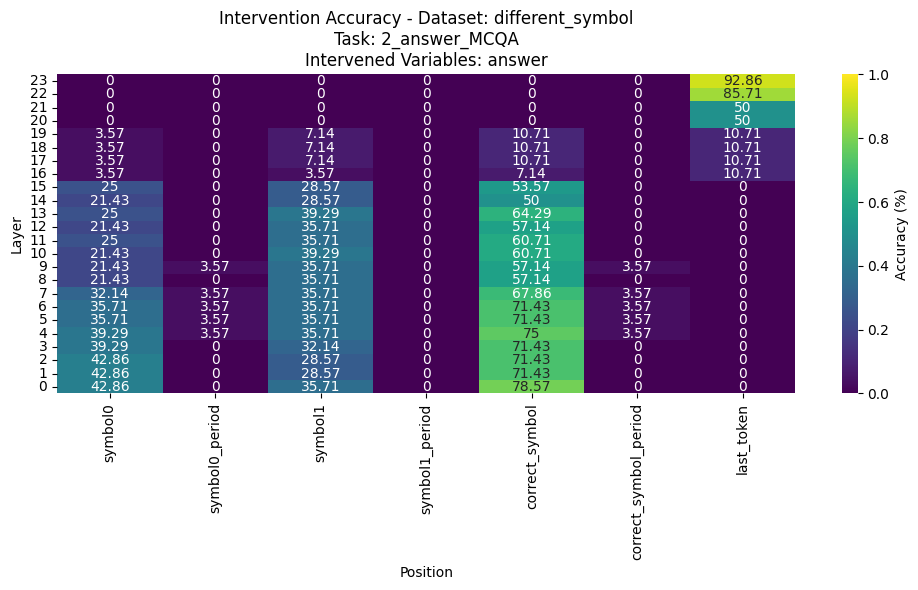

In [7]:
diff_results = copy.deepcopy(raw_results)
del diff_results["dataset"]["same_symbol_different_position"]
del diff_results["dataset"]["random_counterfactual"]


causal_model.can_distinguish_with_dataset(different_symbol_pairs, ["answer"], None)
causal_model.can_distinguish_with_dataset(different_symbol_pairs, ["answer"], ["answer_position"])

print("\nHeatmap for 'answer' variable:")
experiment.plot_heatmaps(diff_results, ["answer"], save_path=results_dir)

This dataset confounds the answer_position variable with no intervention, meaning interchange intervention accuracy on this dataset is perfect when the model output doesn't change.  
This results in all of the causall irrelevant locations in the residual stream to light up in the heatmap. Further more, the locations that store the answer variable are dull on the heatmap because those locations result in the model behavior changing. 

Can distinguish between ['answer_position'] and None: 0 out of 64 examples
Proportion of distinguishable examples: 0.00
Can distinguish between ['answer'] and ['answer_position']: 64 out of 64 examples
Proportion of distinguishable examples: 1.00

Heatmap for 'answer_position' variable:
vector_patching_results/heatmap_dataset_different_symbol_task_2_answer_MCQA_variables_answer_position.png


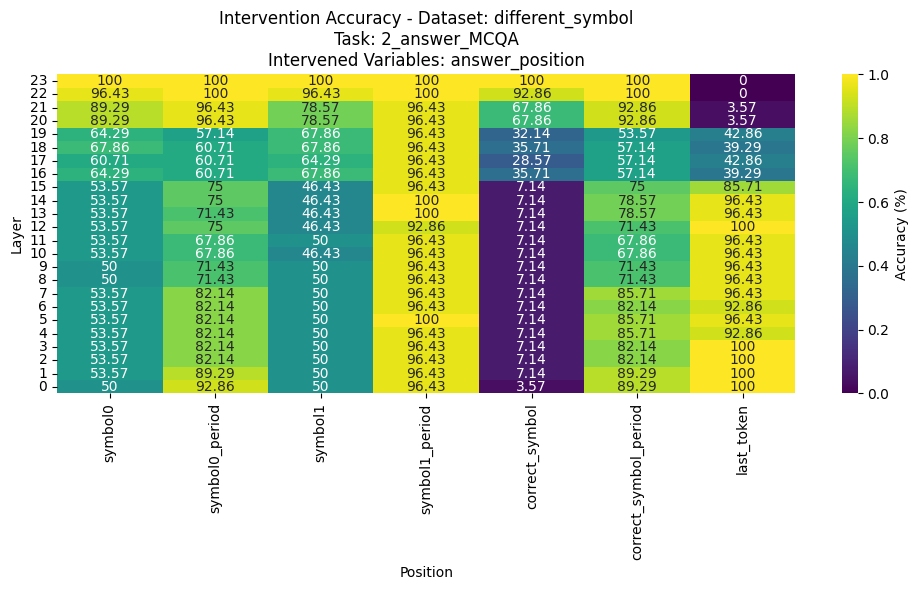

In [8]:
causal_model.can_distinguish_with_dataset(different_symbol_pairs, ["answer_position"], None)
causal_model.can_distinguish_with_dataset(different_symbol_pairs, ["answer"], ["answer_position"])
print("\nHeatmap for 'answer_position' variable:")
experiment.plot_heatmaps(diff_results, ["answer_position"], save_path=results_dir)

## Different Symbol Counterfactual Results (Localizing the Answer Position Variable)

Next, we load the counterfactual dataset designed to localize the position of the output variable of the causal model that is then dereferenced to retrieve the actual token.
The original and counterfactual inputs in this dataset have the same output, but that output is stored in different positions.

In [9]:
print(same_symbol_diff_position_pairs[0])
print("Original input:")
print(same_symbol_diff_position_pairs[0]["input"]["raw_input"])
print("\nCounterfactual input:")
print(same_symbol_diff_position_pairs[0]["counterfactual_inputs"][0]["raw_input"])

{'input': {'choice0': 'orange', 'choice1': 'yellow', 'object_color': ['lemon', 'yellow'], 'raw_input': 'The lemon is yellow. What color is the lemon?\nH. orange\nT. yellow\nAnswer:', 'symbol0': 'H', 'symbol1': 'T', 'template': 'The <object> is <color>. What color is the <object>?\n<symbol0>. <choice0>\n<symbol1>. <choice1>\nAnswer:'}, 'counterfactual_inputs': [{'choice0': 'yellow', 'choice1': 'orange', 'object_color': ['lemon', 'yellow'], 'raw_input': 'The lemon is yellow. What color is the lemon?\nT. yellow\nH. orange\nAnswer:', 'symbol0': 'T', 'symbol1': 'H', 'template': 'The <object> is <color>. What color is the <object>?\n<symbol0>. <choice0>\n<symbol1>. <choice1>\nAnswer:'}]}
Original input:
The lemon is yellow. What color is the lemon?
H. orange
T. yellow
Answer:

Counterfactual input:
The lemon is yellow. What color is the lemon?
T. yellow
H. orange
Answer:



This dataset can distinguish the answer position variable from the answer position variable and no intervention (see the first notebook for a more extended explanation). 

Observe that the answer position variable has some signal (around 50%) for the first and second symbol positions, howeve this is due to these interventions resulting in the same symbol occurring twice in context. Half the time, the remaining symbol is the expected output. 

Otherwise, it seems that only a single layer, i.e., layer 15, contains a notable signal for the answer position variable.

Can distinguish between ['answer_position'] and None: 64 out of 64 examples
Proportion of distinguishable examples: 1.00
Can distinguish between ['answer'] and ['answer_position']: 64 out of 64 examples
Proportion of distinguishable examples: 1.00

Heatmap for 'answer_position' variable:
vector_patching_results/heatmap_dataset_same_symbol_different_position_task_2_answer_MCQA_variables_answer_position.png


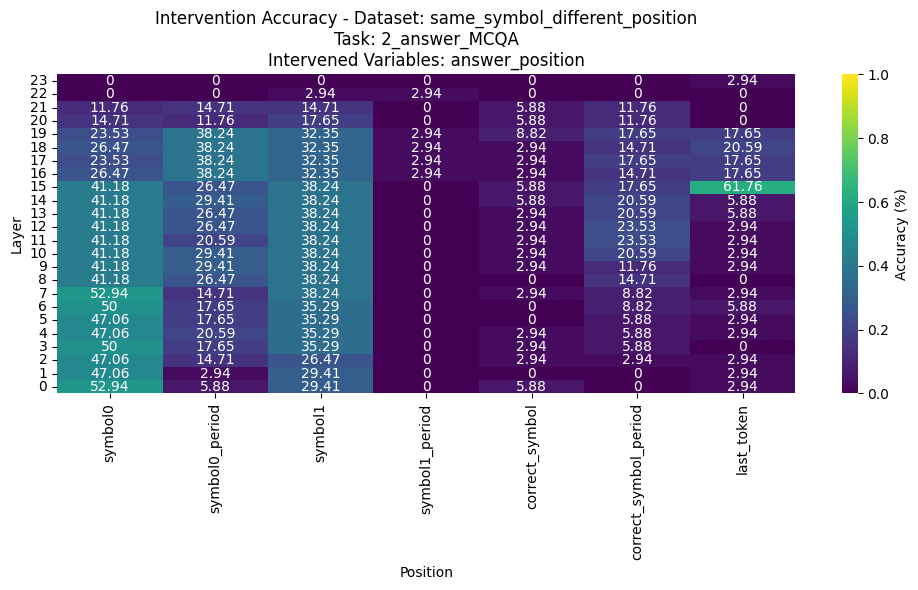

In [10]:
same_diff_results = copy.deepcopy(raw_results)
del same_diff_results["dataset"]["different_symbol"]
del same_diff_results["dataset"]["random_counterfactual"]


causal_model.can_distinguish_with_dataset(same_symbol_diff_position_pairs, ["answer_position"], None)
causal_model.can_distinguish_with_dataset(same_symbol_diff_position_pairs, ["answer"], ["answer_position"])

print("\nHeatmap for 'answer_position' variable:")
experiment.plot_heatmaps(same_diff_results, ["answer_position"], save_path=results_dir)

This dataset confounds the answer variable with no intervention, meaning interchange intervention accuracy on this dataset is perfect when the model output doesn't change.  
This results in all of the causall irrelevant locations in the residual stream to light up in the heatmap. Further more, the single location with the best signal for the answer position variable is dull on the heatmap because that location result in the model behavior changing. 

Can distinguish between ['answer'] and None: 0 out of 64 examples
Proportion of distinguishable examples: 0.00
Can distinguish between ['answer'] and ['answer']: 0 out of 64 examples
Proportion of distinguishable examples: 0.00

Heatmap for 'answer' variable:
vector_patching_results/heatmap_dataset_same_symbol_different_position_task_2_answer_MCQA_variables_answer.png


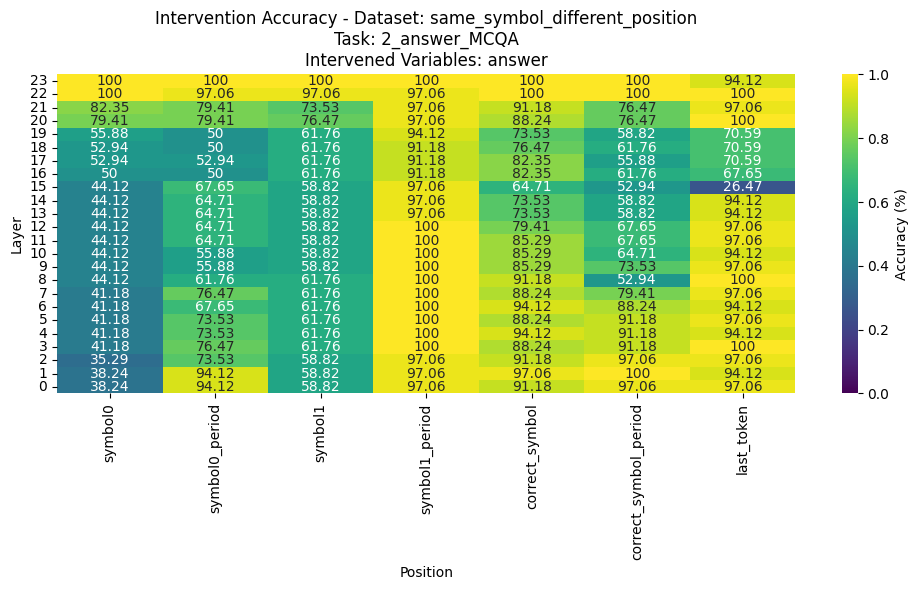

In [11]:
causal_model.can_distinguish_with_dataset(same_symbol_diff_position_pairs, ["answer"], None)
causal_model.can_distinguish_with_dataset(same_symbol_diff_position_pairs, ["answer"], ["answer"])

print("\nHeatmap for 'answer' variable:")
experiment.plot_heatmaps(same_diff_results, ["answer"], save_path=results_dir)

## Random Counterfactual Results

The previous datsets were constructed to easily localize the answer and the answer position variables. However, they only contain counterfactual inputs that match the question and choices of the original input. A random counterfactual will have an entirely new question, choices, and symbols, which makes this a experiment with fully distinct counterfactuals from the other datasets!

In [12]:
print(random_pairs[0])
print("Original input:")
print(random_pairs[0]["input"]["raw_input"])
print("\nCounterfactual input:")
print(random_pairs[0]["counterfactual_inputs"][0]["raw_input"])

{'input': {'choice0': 'brown', 'choice1': 'white', 'object_color': ['cauliflower', 'white'], 'raw_input': 'The cauliflower is white. What color is the cauliflower?\nJ. brown\nE. white\nAnswer:', 'symbol0': 'J', 'symbol1': 'E', 'template': 'The <object> is <color>. What color is the <object>?\n<symbol0>. <choice0>\n<symbol1>. <choice1>\nAnswer:'}, 'counterfactual_inputs': [{'choice0': 'blue', 'choice1': 'green', 'object_color': ['blueberry', 'blue'], 'raw_input': 'The blueberry is blue. What color is the blueberry?\nC. blue\nY. green\nAnswer:', 'symbol0': 'C', 'symbol1': 'Y', 'template': 'The <object> is <color>. What color is the <object>?\n<symbol0>. <choice0>\n<symbol1>. <choice1>\nAnswer:'}]}
Original input:
The cauliflower is white. What color is the cauliflower?
J. brown
E. white
Answer:

Counterfactual input:
The blueberry is blue. What color is the blueberry?
C. blue
Y. green
Answer:


Localizing the answer position variable with the random counterfactuals is similar to the results with the same_symbol_different_position counterfactuals, because we again see that the residual stream of the last token at layer 15 contains the strongest positional signal. However, because the counterfactuals contain entirely new symbols---instead of the same symbols swapped as is the case for the same_symbol_different_position counterfactuals---the signal above the two symbol tokens is lower.

Can distinguish between ['answer_position'] and None: 39 out of 64 examples
Proportion of distinguishable examples: 0.61
Can distinguish between ['answer'] and ['answer_position']: 63 out of 64 examples
Proportion of distinguishable examples: 0.98

Heatmap for 'answer_position' variable:
vector_patching_results/heatmap_dataset_random_counterfactual_task_2_answer_MCQA_variables_answer_position.png


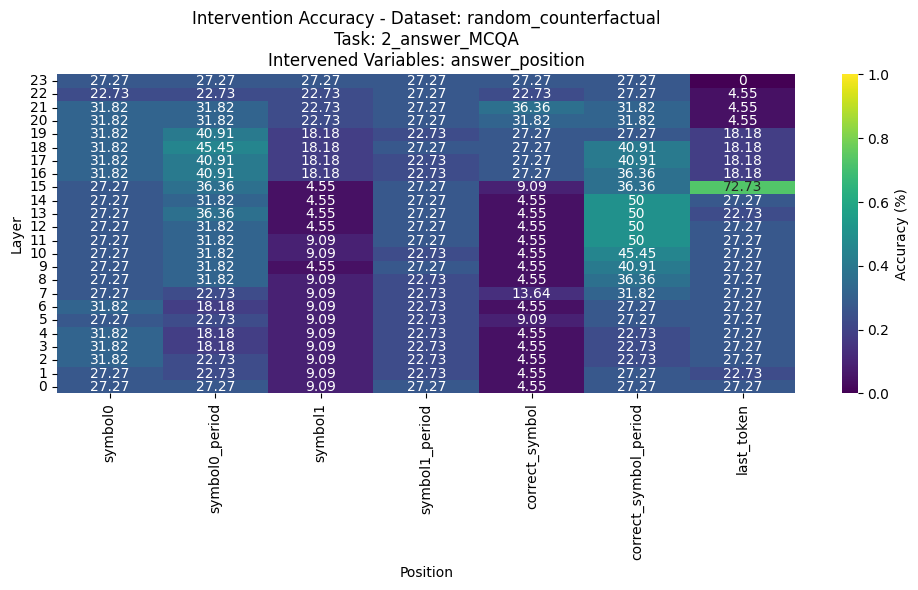

In [13]:
random_results = copy.deepcopy(raw_results)
del random_results["dataset"]["different_symbol"]
del random_results["dataset"]["same_symbol_different_position"]


causal_model.can_distinguish_with_dataset(random_pairs, ["answer_position"], None)
causal_model.can_distinguish_with_dataset(random_pairs, ["answer"], ["answer_position"])

print("\nHeatmap for 'answer_position' variable:")
experiment.plot_heatmaps(random_results, ["answer_position"], save_path=results_dir)

Localizing the answer position variable with the random counterfactuals provides similar results to localizing with the different symbol counterfactuals. The main difference is that the signal above the correct symbol is lower, likely due to Qwen's poor performance on the task and the interventions at the lower layers constructing new inputs that might not have passed the filtering stage.     

Can distinguish between ['answer'] and None: 61 out of 64 examples
Proportion of distinguishable examples: 0.95
Can distinguish between ['answer'] and ['answer_position']: 63 out of 64 examples
Proportion of distinguishable examples: 0.98

Heatmap for 'answer' variable:
vector_patching_results/heatmap_dataset_random_counterfactual_task_2_answer_MCQA_variables_answer.png


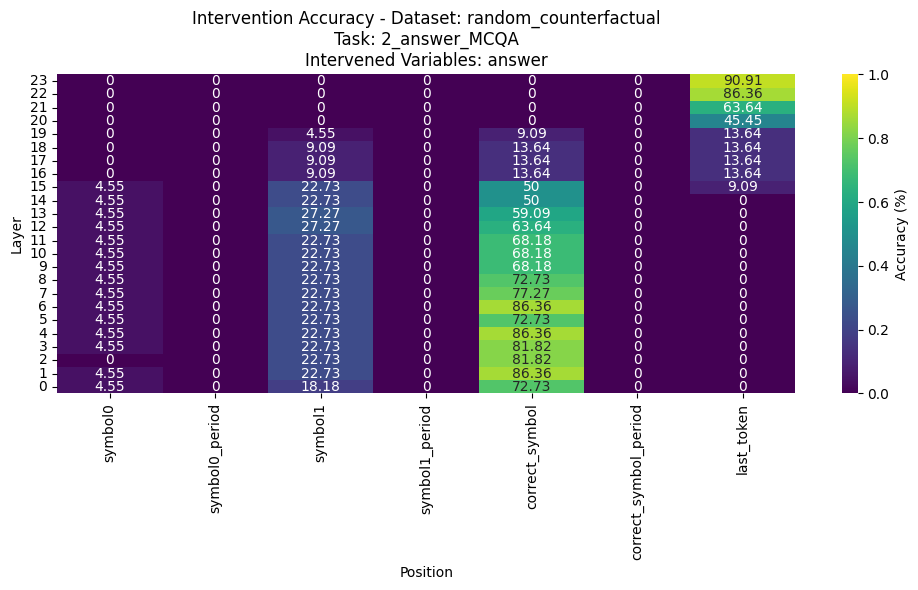

In [14]:
causal_model.can_distinguish_with_dataset(random_pairs, ["answer"], None)
causal_model.can_distinguish_with_dataset(random_pairs, ["answer"], ["answer_position"])

print("\nHeatmap for 'answer' variable:")
experiment.plot_heatmaps(random_results, ["answer"], save_path=results_dir)

# Takeaway

Intervening on the entire residual stream vector is a crude operation that lacks any precision. However, we can see it is a powerful tool that can immediately give us a quantitative and qualitative impression of how the network processes inofmration to solve a task! We can also see the crucial role of designing counterfactual datasets in testing hypothesized causal abstractions.

No single counterfactual dataset is sufficient to localize causal variables within a neural network. Instead, we should build up a number of diagnostic datasets and precisely quantify their ability to discriminate between hypotheses. If we see surprising results, we can iterate and redesign the causal model or the counterfactual datasets to formulate a new hypothesis.